In [215]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from sklearn import metrics

В этом ноутбуке я анализирую датасет с характеристиками треков из Spotify. В нем 42305 строк. 
Ищу корреляции, строю регрессии и проверяю модели на втором датасете из Spotily ниже.

<b>Загружаем данные</b>

In [216]:
cols = [*range(11)] + [16, 17, 18, 19, 21]  # список без лишних колонок
songs = pd.read_csv('spotify_genres_v2.csv',
                    low_memory=False,
                    usecols=cols,
                    dtype={'genre':'category', 'mode':'category'})

display(songs)
songs.info()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre,song_name,title
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539,4,Dark Trap,Mercury: Retrograde,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427,4,Dark Trap,Pathology,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821,4,Dark Trap,Symbiote,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298,4,Dark Trap,Venom,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,4,hardstyle,NaN,Euphoric Hardstyle
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,4,hardstyle,NaN,Greatest Hardstyle Playlist
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,4,hardstyle,NaN,Best of Hardstyle 2020
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,4,hardstyle,NaN,Euphoric Hardstyle


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   danceability      42305 non-null  float64 
 1   energy            42305 non-null  float64 
 2   key               42305 non-null  int64   
 3   loudness          42305 non-null  float64 
 4   mode              42305 non-null  category
 5   speechiness       42305 non-null  float64 
 6   acousticness      42305 non-null  float64 
 7   instrumentalness  42305 non-null  float64 
 8   liveness          42305 non-null  float64 
 9   valence           42305 non-null  float64 
 10  tempo             42305 non-null  float64 
 11  duration_ms       42305 non-null  int64   
 12  time_signature    42305 non-null  int64   
 13  genre             42305 non-null  category
 14  song_name         21519 non-null  object  
 15  title             20780 non-null  object  
dtypes: category(2), float6

In [217]:
songs[songs['title'].notna() & songs['song_name'].notna()]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre,song_name,title


In [218]:
songs['song_name'].fillna(songs['title'], inplace=True)
songs.drop('title', axis=1, inplace=True)
len(songs['song_name'].notna())

42305

In [219]:
songs.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000
mean,0.639364,0.762516,5.370240,-6.465442,0.136561,0.096160,0.283048,0.214079,0.357101,147.474056,250865.846685,3.972580
std,0.156617,0.183823,3.666145,2.941165,0.126168,0.170827,0.370791,0.175576,0.233200,23.844623,102957.713571,0.268342
min,0.065100,0.000243,0.000000,-33.357000,0.022700,0.000001,0.000000,0.010700,0.018700,57.967000,25600.000000,1.000000
25%,0.524000,0.632000,1.000000,-8.161000,0.049100,0.001730,0.000000,0.099600,0.161000,129.931000,179840.000000,4.000000
50%,0.646000,0.803000,6.000000,-6.234000,0.075500,0.016400,0.005940,0.135000,0.322000,144.973000,224760.000000,4.000000
75%,0.766000,0.923000,9.000000,-4.513000,0.193000,0.107000,0.722000,0.294000,0.522000,161.464000,301133.000000,4.000000
max,0.988000,1.000000,11.000000,3.148000,0.946000,0.988000,0.989000,0.988000,0.988000,220.290000,913052.000000,5.000000



Самый короткий трек в датасете длится 25 сек.

In [220]:
songs[songs['duration_ms'] == songs['duration_ms'].min()][['song_name', 'duration_ms']]

,song_name,duration_ms
33655,HEADBANGERS:Dubstep/Riddim,25600


Самые танцевабельные треки оказались в жанре Hiphop и Techno house:

In [221]:
songs[songs['danceability'] == songs['danceability'].max()][['song_name', 'genre', 'danceability']]

,song_name,genre,danceability
19066,Funky Cold Medina,Hiphop,0.988
22004,Dirtybird Players,techhouse,0.988
22861,tech house,techhouse,0.988


... и самые нетанцевабельные - Trap Metal:

In [222]:
songs[songs['danceability'] == songs['danceability'].min()][['song_name', 'genre', 'danceability']]

,song_name,genre,danceability
10640,Call Of The Baphomet,Trap Metal,0.0651
11732,Call Of The Baphomet,Trap Metal,0.0651


Самые энергичные:

In [223]:
songs[songs['energy'] == songs['energy'].max()][['song_name', 'genre', 'energy']]

,song_name,genre,energy
26695,techno. only. (08/02),techno,1.0
27795,Uplifting | Trance,trance,1.0
28168,Uplifting Trance.,trance,1.0
30048,UPLIFTING TRANCE 2020,trance,1.0
35582,I'm a fucking Headbanger,trap,1.0


Самыми неэнергичными оказались SuicideBoyS

In [224]:
songs[songs['energy'] == songs['energy'].min()][['song_name', 'genre', 'energy']]

,song_name,genre,energy
2239,Kill Yourself - Part II,Dark Trap,0.000243
11425,Kill Yourself - Part II,Trap Metal,0.000243



### Поищем корреляции

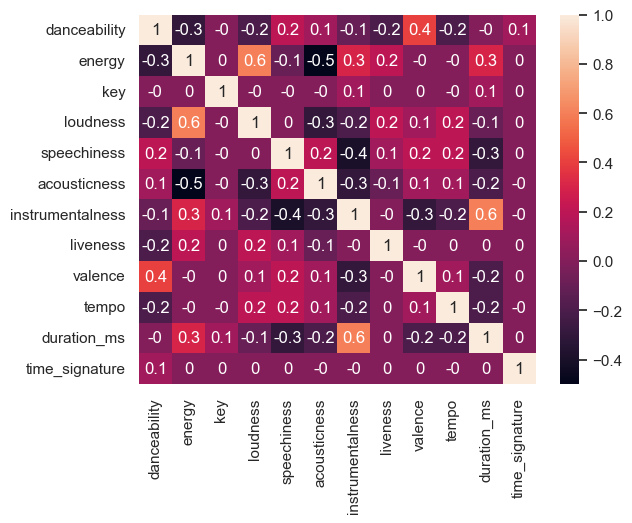

In [225]:
songs_corr = songs.corr().apply(lambda x: round(x, 1))
sns.heatmap(songs_corr, annot=True)
plt.show()

Наибольшая корреляция (0.6) у двух пар:
- Energy-Loudness (энергичность и громкость)
- Duration-Instrumentalness (длительность и отсутствие вокала) 

<b>Energy:</b>
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. 

<b>Loudness:</b>
The overall loudness of a track in decibels (dB).

<b>Duration:</b>
The duration of the track in milliseconds.

<b>Instrumentalness:</b>
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal".


Показатели Time signature и Key, напротив, ни с чем не коррелируют. В дальнейшем они не понадобится. 

[Описание всех переменных](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features)

In [226]:
songs.drop(['time_signature', 'key'], axis=1, inplace=True)

### Loudness vs. Energy

Посмотрим, как связаны громкость и энергичность.

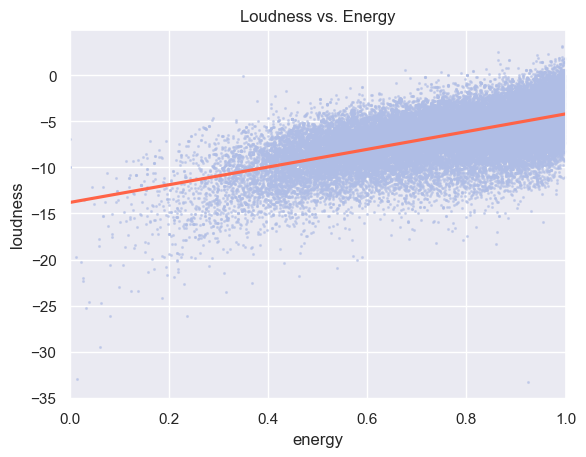

In [227]:
# построим регрессию
sns.set_theme(style="darkgrid")
sns.regplot(x='energy',
            y='loudness',
            data=songs,
            ci=None,
            color='tomato',
            scatter_kws={'alpha': 0.5, 's': 1.5, 'color': '#AFBDE5'}).set(
            title='Loudness vs. Energy')
plt.xlim(0, 1)

plt.show()

In [228]:
mdl_loudness_vs_energy = ols('loudness~energy', data=songs)
mdl_loudness_vs_energy = mdl_loudness_vs_energy.fit()

print(f'R-squeared: {round(mdl_loudness_vs_energy.rsquared, 2)}')

R-squeared: 0.36


Посмотрим, как отличаются эти характеристики по жанрам 

<b>Энергичность</b>

In [229]:
songs.groupby('genre')['energy'].agg(['mean', 'median','std']).sort_values('mean', ascending=False)

,mean,median,std
genre,,,
trap,0.906060,0.9400,0.098066
psytrance,0.902392,0.9340,0.093983
hardstyle,0.896238,0.9190,0.082729
trance,0.892435,0.9300,0.107369
dnb,0.873433,0.9010,0.097925
techhouse,0.834481,0.8730,0.131920
techno,0.795714,0.8225,0.141080
Emo,0.761175,0.8545,0.220404
Trap Metal,0.749157,0.7790,0.174147


In [230]:
trap_rnb = songs[songs['genre'].isin(['trap', 'RnB'])].copy()
trap_rnb['genre'] = trap_rnb['genre'].cat.remove_unused_categories()
trap_rnb.value_counts('genre')

genre
trap    2987
RnB     2099
dtype: int64

Самый неэнергичный и самый энергичный жанр:

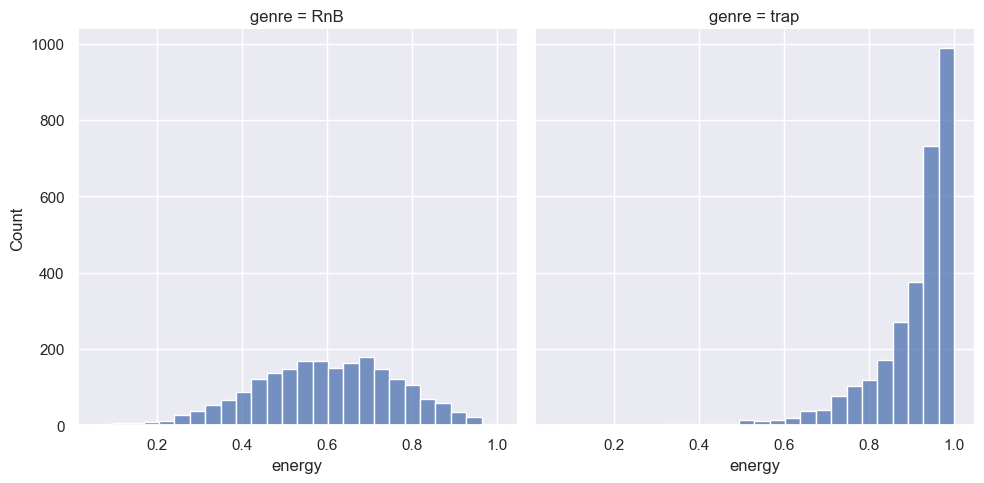

In [231]:
sns.displot(data=trap_rnb,
           x='energy',
           col='genre')

plt.show()


<b>Громкость</b>

In [232]:
songs.groupby('genre')['loudness'].agg(['mean', 'median','std']).sort_values('mean', ascending=False)

,mean,median,std
genre,,,
trap,-2.725578,-2.5350,1.946665
dnb,-4.063237,-3.9720,1.946063
hardstyle,-4.349444,-4.2460,1.589293
Emo,-5.433641,-4.7885,2.598227
Pop,-5.632072,-5.4230,1.947846
Trap Metal,-5.879087,-5.6125,3.038965
psytrance,-6.703383,-6.4750,1.585368
Rap,-6.887086,-6.6365,2.353116
RnB,-6.899896,-6.5310,2.518220


In [233]:
trap_techno = songs[songs['genre'].isin(['trap', 'techno'])].copy()
trap_techno['genre'] = trap_techno['genre'].cat.remove_unused_categories()

Самый громкий и самый тихий жанр:

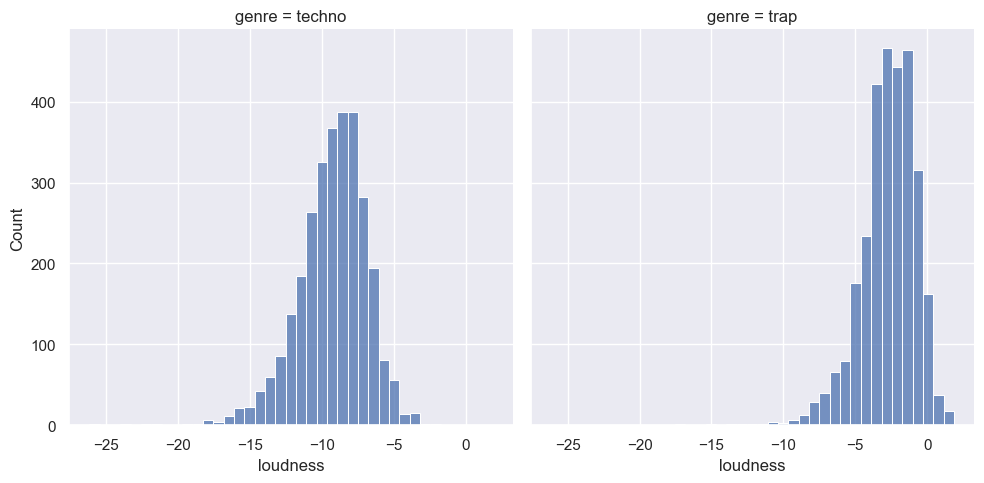

In [234]:
sns.displot(data=trap_techno,
           x='loudness',
           col='genre')

plt.show()

### Duration (ms) vs. Instrumentalness

Чем меньше в песне слов, тем она длиннее

In [235]:
# Треки минимальной и максимальной длины
songs[songs['duration_ms'].isin([
    songs['duration_ms'].max(), 
    songs['duration_ms'].min(),])][['song_name', 'duration_ms', 'instrumentalness']]

,song_name,duration_ms,instrumentalness
31428,PSYTRANCE BANGERS best new 2020,913052,0.823
33655,HEADBANGERS:Dubstep/Riddim,25600,0.829


In [236]:
# instrumentalness по жанрам
songs.groupby('genre')['instrumentalness'].agg(['mean', 'median', 'std']).sort_values('mean')

,mean,median,std
genre,,,
Rap,0.006939,0.000000,0.058052
RnB,0.007400,0.000000,0.060419
Emo,0.011402,0.000000,0.077927
Pop,0.013831,0.000000,0.085986
Hiphop,0.017154,0.000000,0.093075
Underground Rap,0.025280,0.000000,0.116380
Trap Metal,0.057051,0.000012,0.177845
hardstyle,0.137431,0.003275,0.253083
trap,0.196289,0.035700,0.273228



<b>Регрессия</b>

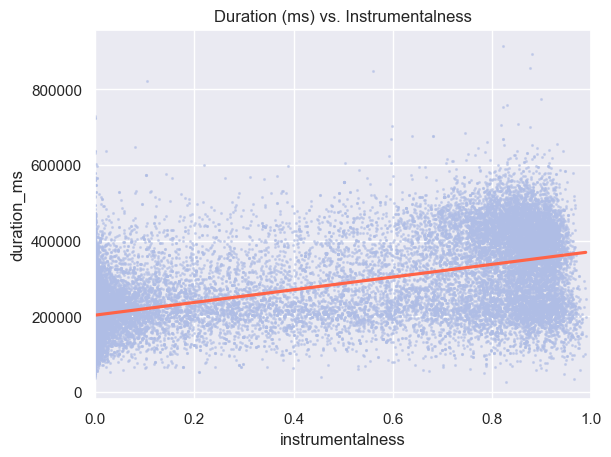

In [237]:
sns.regplot(x='instrumentalness',
            y='duration_ms',
            data=songs,
            ci=None,
            color='tomato',
            scatter_kws={'alpha': 0.5, 's': 1.5, 'color': '#AFBDE5'}).set(
            title='Duration (ms) vs. Instrumentalness')
plt.xlim(0, 1)

plt.show()

In [238]:
mdl_duration_vs_instrument = ols('duration_ms~instrumentalness', data=songs)
mdl_duration_vs_instrument = mdl_duration_vs_instrument.fit()

print(f'R-squeared: {round(mdl_duration_vs_instrument.rsquared, 2)}')

R-squeared: 0.36


Плотность Instrumentalness выше у крайних значений (0 - в песне много вокала, 1 - вокала нет). Посмотрим на распределения.


<b>Instrumentalness</b>

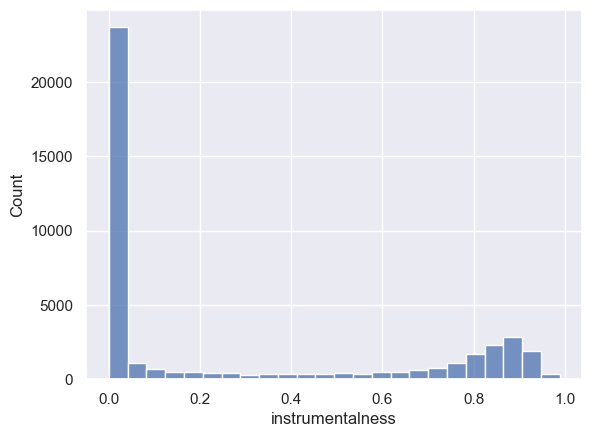

In [239]:
sns.histplot(data=songs,
            x='instrumentalness')
plt.show()

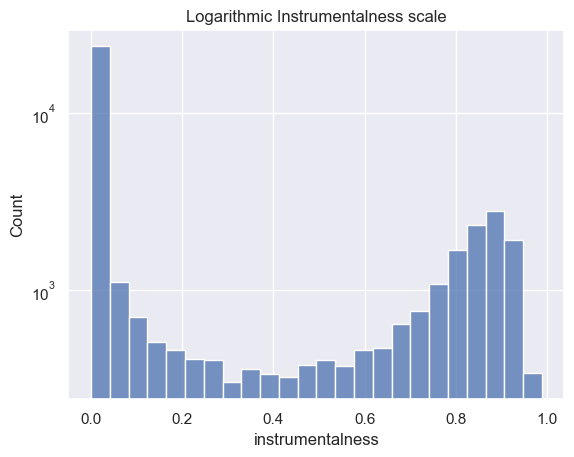

In [240]:
sns.histplot(data=songs,
            x='instrumentalness').set(title='Logarithmic Instrumentalness scale')
plt.yscale('log')
plt.show()


<b>Длительность</b>

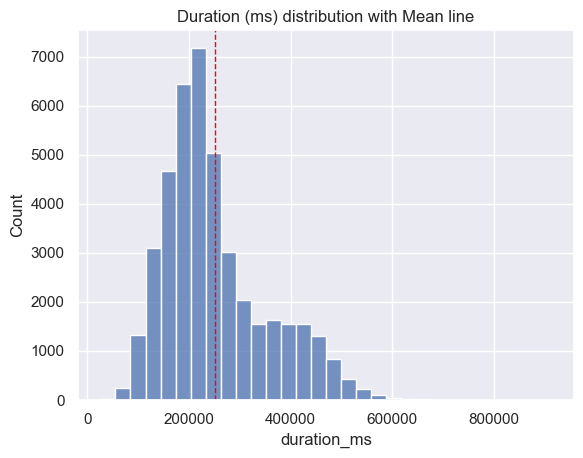

In [241]:
sns.histplot(data=songs,
            x='duration_ms',
            bins=30).set(title='Duration (ms) distribution with Mean line')

plt.axvline(x=songs['duration_ms'].mean(),
            color='red',
            ls='--',
            lw=1
           )
plt.show()

Распределение длительности, в отличие от instrumentalness, напоминает нормальное (right-skewed).


### Проанализируем еще один датасет из Spotify

Загрузим еще один датасет из Spotify с теми же переменными, который я нашла позже. Он больше и сбалансирован по жанрам. В нем 114К строк, по 1000 на каждый жанр. Посмотрим, можно ли использовать модели из первого датасета на нем.


In [242]:
# используем для загрузки имена колонок, которые есть в первом датасете
spotify_features = list(songs.columns)
spotify_features[-1:-3:-1] = ['track_name', 'track_genre']

songs_2 = pd.read_csv('spotify_dataset2.csv',
                      low_memory=False,
                      usecols=spotify_features,
                      dtype={'genre':'category', 'mode':'category'}
                     )

songs_2.rename(columns={'track_name': 'song_name', 'track_genre': 'genre'}, inplace=True)
display(songs_2)
songs_2.info()

,song_name,duration_ms,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Comedy,230666,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,acoustic
1,Ghost - Acoustic,149610,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,acoustic
2,To Begin Again,210826,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,acoustic
3,Can't Help Falling In Love,201933,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,acoustic
4,Hold On,198853,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,Sleep My Little Boy,384999,0.172,0.2350,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,world-music
113996,Water Into Light,385000,0.174,0.1170,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,world-music
113997,Miss Perfumado,271466,0.629,0.3290,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,world-music
113998,Friends,283893,0.587,0.5060,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,world-music


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   song_name         113999 non-null  object  
 1   duration_ms       114000 non-null  int64   
 2   danceability      114000 non-null  float64 
 3   energy            114000 non-null  float64 
 4   loudness          114000 non-null  float64 
 5   mode              114000 non-null  category
 6   speechiness       114000 non-null  float64 
 7   acousticness      114000 non-null  float64 
 8   instrumentalness  114000 non-null  float64 
 9   liveness          114000 non-null  float64 
 10  valence           114000 non-null  float64 
 11  tempo             114000 non-null  float64 
 12  genre             114000 non-null  object  
dtypes: category(1), float64(9), int64(1), object(2)
memory usage: 10.5+ MB


In [243]:
len(songs.columns) == len(songs_2.columns)

True

In [244]:
songs_2.describe()

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,2.280292e+05,0.566800,0.641383,-8.258960,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837
std,1.072977e+05,0.173542,0.251529,5.029337,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197
min,0.000000e+00,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.740660e+05,0.456000,0.472000,-10.013000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750
50%,2.129060e+05,0.580000,0.685000,-7.004000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000
75%,2.615060e+05,0.695000,0.854000,-5.003000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000
max,5.237295e+06,0.985000,1.000000,4.532000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000


In [245]:
songs_2['genre'].value_counts()

acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: genre, Length: 114, dtype: int64

<b>Жанры в датасете:</b>

In [246]:
print(songs_2['genre'].unique())

['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
 'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
 'reggaeton' 'rock-n-roll' 'rock' 'rockabilly' 'romance' 'sad' 'salsa'
 'samba' 'sertanejo' 'show

<b>Корреляции</b>

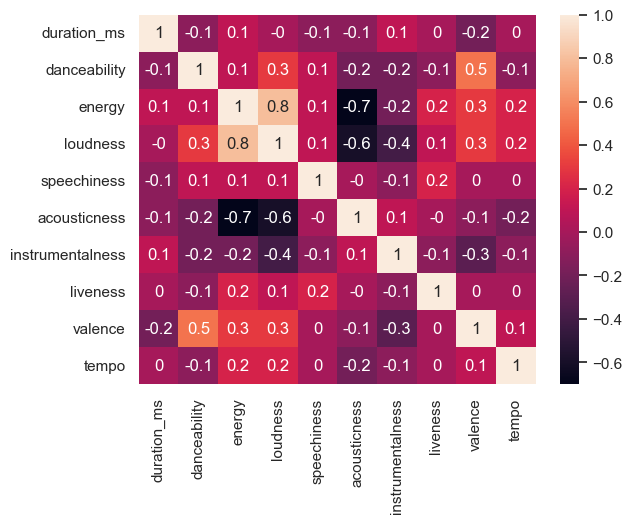

In [247]:
songs_corr_2 = songs_2.corr().apply(lambda x: round(x, 1))
sns.heatmap(songs_corr_2, annot=True)
plt.show()

<b>Loudness</b> и <b>Energy</b> также коррелирую, даже больше, чем в первом датасете. А вот <b>Instrumentalness</b> и <b>Duration</b> - практически совсем нет. Duration не коррелирует ни с одной из переменных. Зато <b>Acousticness</b> отрицательно коррелирует с <b>Energy</b>.


Посмотрим для начала, что стало с Instrumentalness.

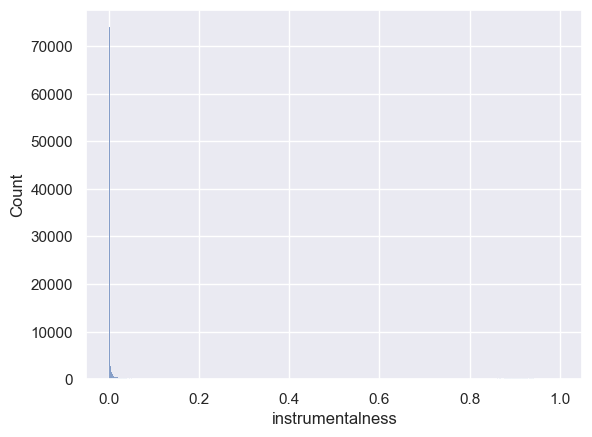

In [248]:
sns.histplot(data=songs_2,
            x='instrumentalness')
plt.show()

В этом датасете значительно больше нулевых Instrumentalness, то есть треков с вокалом.

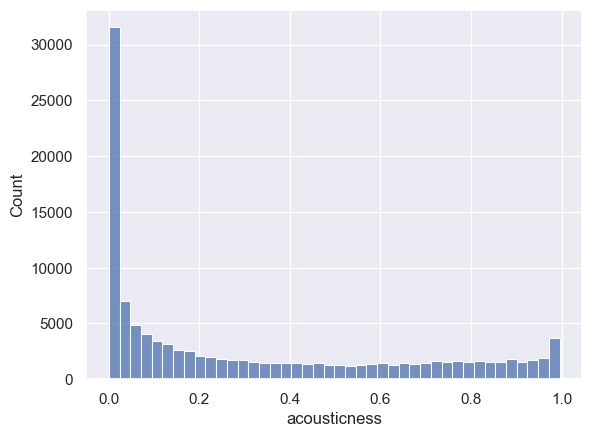

In [249]:
sns.histplot(data=songs_2,
            x='acousticness')
plt.show()

И, в отиличие от первого датасета, меньше нулевых Acousticness.

In [250]:
print('Доля Acousticness < 0.1 в первом датасете: {}'.format(
    round(songs['acousticness'].value_counts(bins=10, normalize=True)[0], 2)))

print('Доля Acousticness < 0.1 во втором датасете: {}'.format(
    round(songs_2['acousticness'].value_counts(bins=10, normalize=True)[0], 2)))

Доля Acousticness < 0.1 в первом датасете: 0.74
Доля Acousticness < 0.1 во втором датасете: 0.42


In [251]:
print('Доля Instrumentalness < 0.1 в первом датасете: {}'.format(
    round(songs['instrumentalness'].value_counts(bins=10, normalize=True)[0], 2)))

print('Доля Instrumentalness <= 0.1 во втором датасете: {}'.format(
    round(songs_2['instrumentalness'].value_counts(bins=10, normalize=True)[0], 2)))

Доля Instrumentalness < 0.1 в первом датасете: 0.59
Доля Instrumentalness <= 0.1 во втором датасете: 0.77



### Используем модель из первого датасета

In [255]:
explanatory_data = pd.DataFrame(songs_2['energy'].copy())

predicted_loudness = mdl_loudness_vs_energy.predict(explanatory_data)

prediction_data = explanatory_data.assign(
    predicted_loudness = predicted_loudness,
    actual_loudness = songs_2['loudness'])

print(prediction_data)

        energy  predicted_loudness  actual_loudness
0       0.4610           -9.367416           -6.746
1       0.1660          -12.206680          -17.235
2       0.3590          -10.349127           -9.734
3       0.0596          -13.230740          -18.515
4       0.4430           -9.540659           -9.681
...        ...                 ...              ...
113995  0.2350          -11.542581          -16.393
113996  0.1170          -12.678286          -18.318
113997  0.3290          -10.637866          -10.895
113998  0.5060           -8.934308          -10.889
113999  0.4870           -9.117176          -10.204

[114000 rows x 3 columns]


<b>Mean Absolute Error (MAE)</b>

In [268]:
metrics.mean_absolute_error(y_true=prediction_data['actual_loudness'],
                            y_pred=prediction_data['predicted_loudness']
                           )

2.3095760298544845

<b>Root Mean Square Error (RMSE)</b> 

In [271]:
np.sqrt(metrics.mean_squared_error(y_true=prediction_data['actual_loudness'],
                                   y_pred=prediction_data['predicted_loudness']
                                  )
       )

3.6056850006496144

In [272]:
abs_error = abs(prediction_data['predicted_loudness'] - prediction_data['actual_loudness'])
abs_error.agg(['mean', 'std'])

mean    2.309576
std     2.768915
dtype: float64

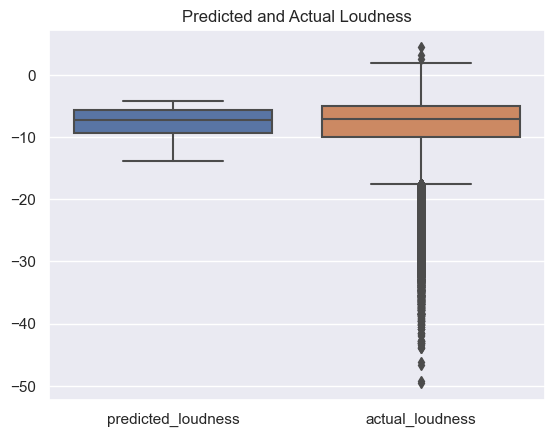

In [261]:
sns.boxplot(data=prediction_data[['predicted_loudness', 'actual_loudness']]).set(
    title='Predicted and Actual Loudness'
)

plt.show()

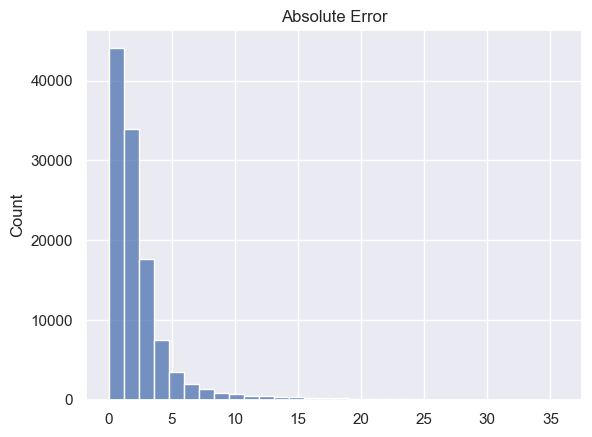

In [273]:
sns.histplot(data=abs_error, bins=30).set(title='Absolute Error')

plt.show()